# File and libraries

In [1]:
import pandas as pd
import numpy as np




filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [3]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    df = df.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
    
else:
    df=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    # data=pd.read_csv(sample_filepath)
    # test= pd.read_csv(test_sample_filepath)
    # train= pd.read_csv(train_sample_filepath)
 
target='is_purchase'
eval_metric_1='precision'
eval_metric_2='f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235411 entries, 0 to 235410
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   is_purchase          235411 non-null  int64  
 1   activity_in_session  235411 non-null  float64
 2   week_of_month        235411 non-null  int64  
 3   is_weekend           235411 non-null  int64  
 4   day                  235411 non-null  int64  
 5   time_of_day_sin      235411 non-null  float64
 6   time_of_day_cos      235411 non-null  float64
 7   day_of_week_sin      235411 non-null  float64
 8   day_of_week_cos      235411 non-null  float64
 9   hour_sin             235411 non-null  float64
 10  hour_cos             235411 non-null  float64
 11  min_sin              235411 non-null  float64
 12  min_cos              235411 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 25.1 MB


# Distribution Check

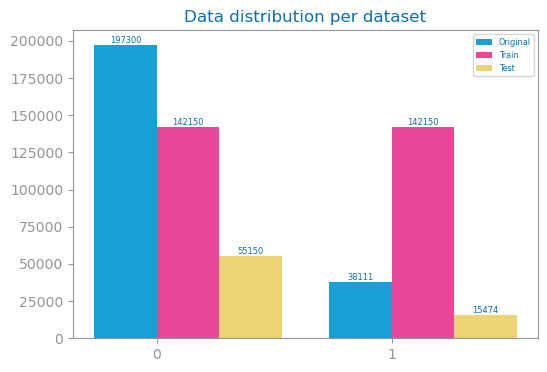

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [6]:

from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# adapted to read from memory
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Reads training and test data from either CSV files or DataFrames, and splits
    the data into features and target.

    Parameters:
    -----------
    train_fn : Union[str, DataFrame]
        File path to the training CSV or a DataFrame object.
    test_fn : Union[str, DataFrame]
        File path to the test CSV or a DataFrame object.
    target : str, default="class"
        The name of the target column.

    Returns:
    --------
    tuple : (trnX, tstX, trnY, tstY, labels, features)
        - trnX: Training feature set as ndarray.
        - tstX: Test feature set as ndarray.
        - trnY: Training labels as array.
        - tstY: Test labels as array.
        - labels: List of unique target values.
        - features: List of feature names (column names).
    """
    # Check if train_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Use the provided DataFrame directly

    # Extract and sort unique target labels
    labels: list = list(train[target].unique())
    labels.sort()

    # Separate features (X) and target (Y) for training data
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Check if test_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Use the provided DataFrame directly

    # Separate features (X) and target (Y) for test data
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()



In [7]:
from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# Função para ler os dados de treino e teste
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Lê dados de treino e teste de arquivos CSV ou DataFrames e separa as características e o alvo.

    (Documentação da função...)
    """
    # Verificar se train_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Extrair e ordenar os rótulos de alvo únicos
    labels: list = list(train[target].unique())
    labels.sort()

    # Separar características (X) e alvo (Y) para dados de treino
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Verificar se test_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Separar características (X) e alvo (Y) para dados de teste
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

# Exemplo de uso da função
if evaluate == True:
    # Verifica o tipo de train e test
    print(f'Train: {train}, type: {type(train)}')  # Verifica o tipo de train
    print(f'Test: {test}, type: {type(test)}')      # Verifica o tipo de test

    # Lê os dados usando a função
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)

    # Exibe as informações lidas
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')


Train:         activity_in_session  week_of_month  is_weekend   day  time_of_day_sin  \
0                  3.000000            1.0         0.0   1.0            0.624   
2916               2.000000            1.0         0.0   1.0           -0.975   
2917               6.000000            1.0         0.0   1.0            0.624   
2918               2.000000            1.0         0.0   1.0            0.624   
2919               3.000000            1.0         0.0   1.0            0.624   
...                     ...            ...         ...   ...              ...   
279557             0.000000            3.0         0.0  18.0           -0.975   
279556             2.000000            3.0         0.0  18.0           -0.624   
279555            11.261189            3.0         0.0  18.0           -0.975   
279566             4.000000            3.0         0.0  18.0            0.624   
284299             3.000000            3.0         0.0  18.0            0.000   

        time_of_day_

In [8]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=284300 Test#=70624
Labels=[0, 1]


## d max definition

In [9]:
d_max_eval= 15

## recall evaluation

DT best with entropy and d=4


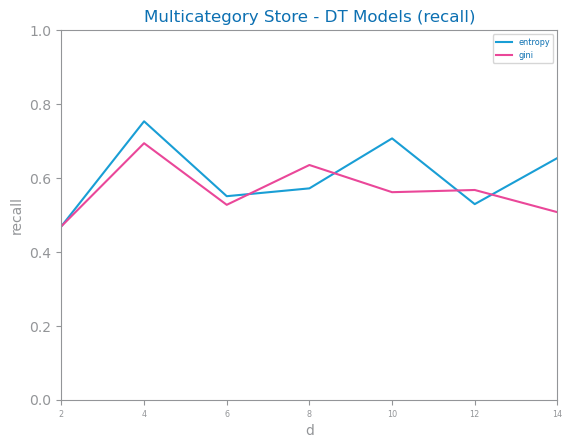

In [10]:
if evaluate==True:

    best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='recall', file_tag=file_tag)
    savefig(f'images/{file_tag}_dt_recall_study.png')
    show()

<Figure size 640x480 with 0 Axes>

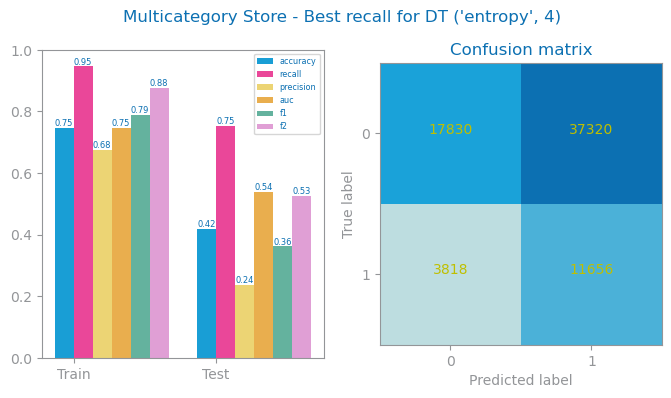

In [11]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

,category_code_lvl_1,category_code_lvl_2,price,activity_in_session,week_of_month,day,brand_value,product_category,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos,is_purchase
0,1.0,8.0,261.55,3.0,2.0,8.0,455.0,4924.0,0.624,-0.781,-0.775,-0.632,0.259,-0.966,0.669,-0.743,0
5720,0.0,6.0,545.70,2.0,2.0,8.0,779.2,4177.0,0.624,-0.781,-0.775,-0.632,0.866,-0.500,0.669,-0.743,0
5719,0.0,3.0,771.94,6.0,2.0,8.0,282.5,2402.0,-0.624,-0.781,-0.775,-0.632,-1.000,-0.000,-0.669,0.743,1
5718,0.0,3.0,140.00,7.0,2.0,8.0,173.5,2138.0,0.624,-0.781,-0.775,-0.632,0.259,-0.966,-0.743,-0.669,1
5717,0.0,1.0,115.04,2.0,2.0,8.0,283.5,1504.0,0.000,1.000,-0.775,-0.632,0.707,0.707,1.000,0.000,0


## evaluate precision

DT best with entropy and d=8


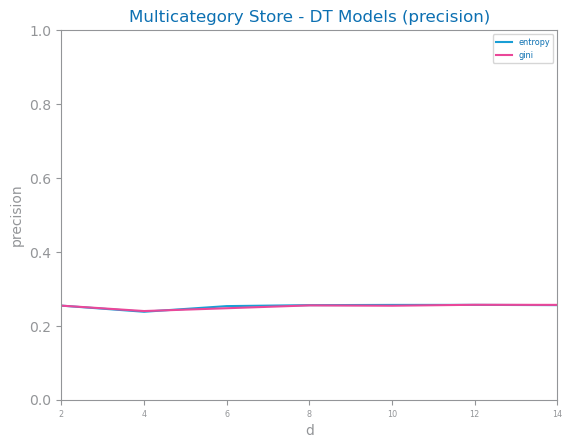

In [12]:
if evaluate==True:

    best_model_prec, prec_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='precision', file_tag=file_tag)
    savefig(f'images/{file_tag}_dt_precision_study.png')
    show()

<Figure size 640x480 with 0 Axes>

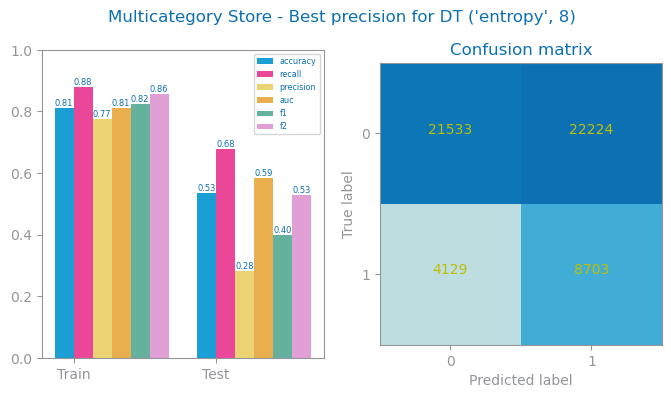

In [14]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

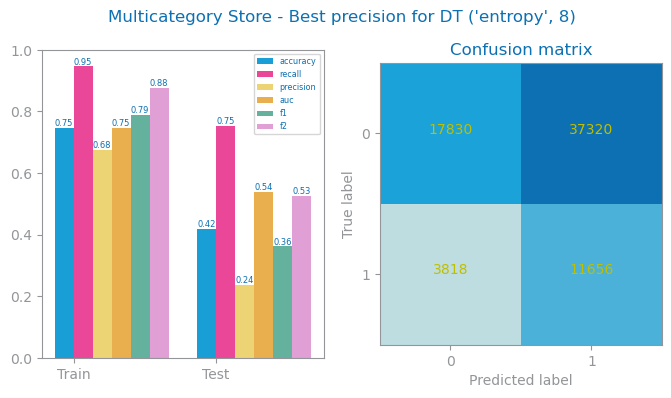

In [13]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## evaluate f2

DT best with entropy and d=6


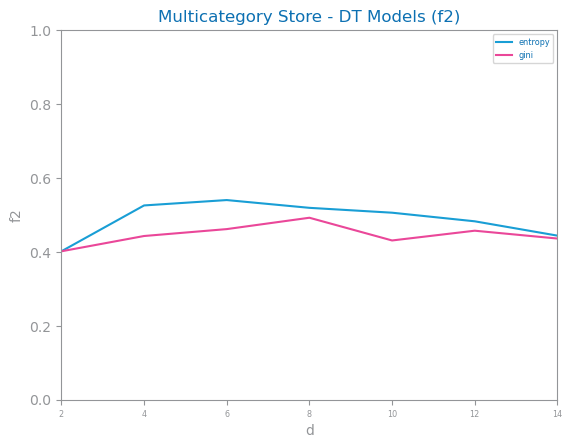

In [14]:
best_model_f2, f2_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='f2',file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["metric"]}_study.png')
show()

<Figure size 640x480 with 0 Axes>

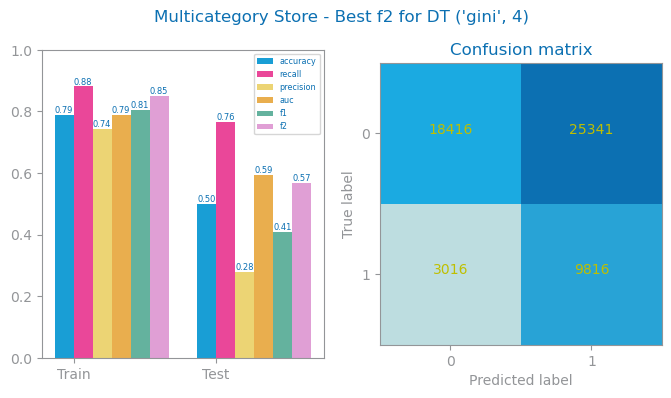

In [16]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

<Figure size 640x480 with 0 Axes>

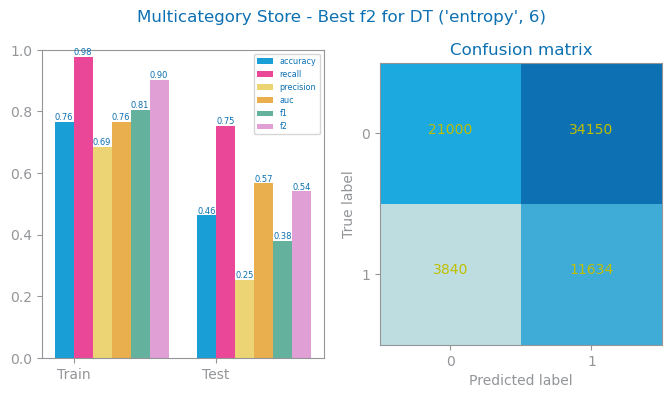

In [16]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Variables importance

# IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ

1. open conda terminal
2. conda install graphviz

### f2 tree evaluation

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.707971 to fit


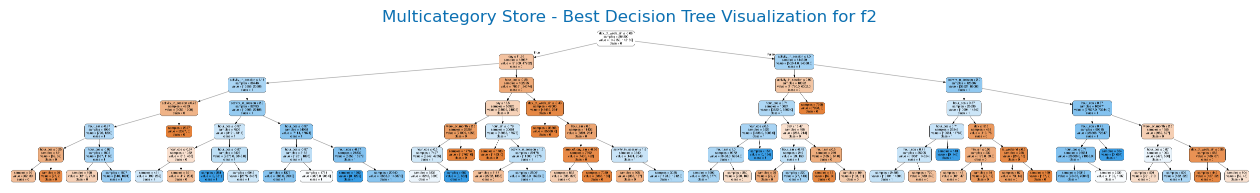

In [17]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis, title
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{f2_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_f2,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(16, 16))
imshow(imread(tree_filename + ".png"))
title(f'{file_tag} - Best Decision Tree Visualization for {f2_params['metric']}')
axis("off")
show()

## f2 simpler tree

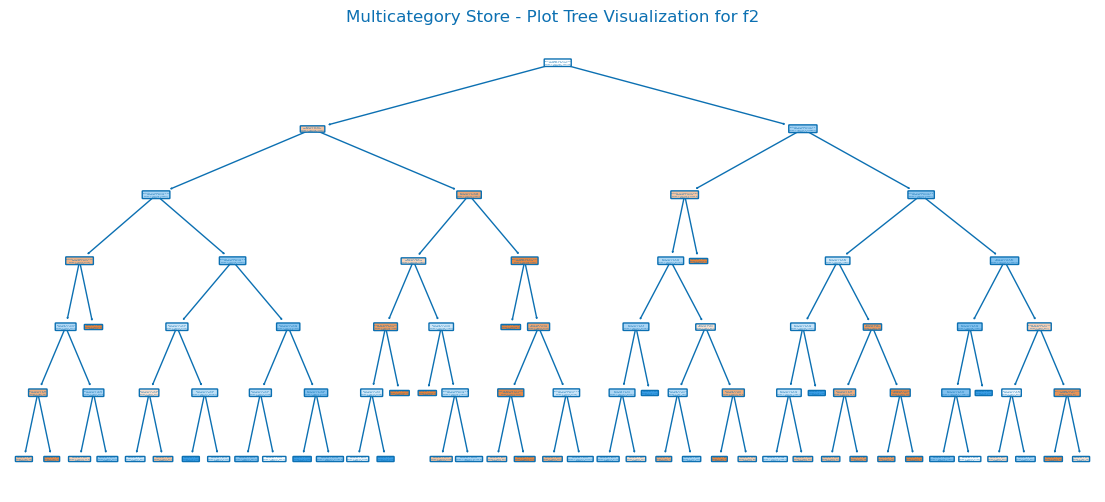

In [18]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import title

figure(figsize=(14, 6))
plot_tree(
    best_model_f2,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")
title(f'{file_tag} - Plot Tree Visualization for {f2_params['metric']}')

show()

# f2 Feature Importances

1. day_of_week_sin (0.26278850055363223)
2. day (0.21199728256791436)
3. activity_in_session (0.20192192972742995)
4. hour_cos (0.17305619803644254)
5. week_of_month (0.09533979485841597)
6. hour_sin (0.04748343458681538)
7. time_of_day_sin (0.007188666436054366)
8. is_weekend (0.00015641209876389065)
9. min_sin (6.778113453154303e-05)
10. min_cos (0.0)
11. day_of_week_cos (0.0)
12. time_of_day_cos (0.0)


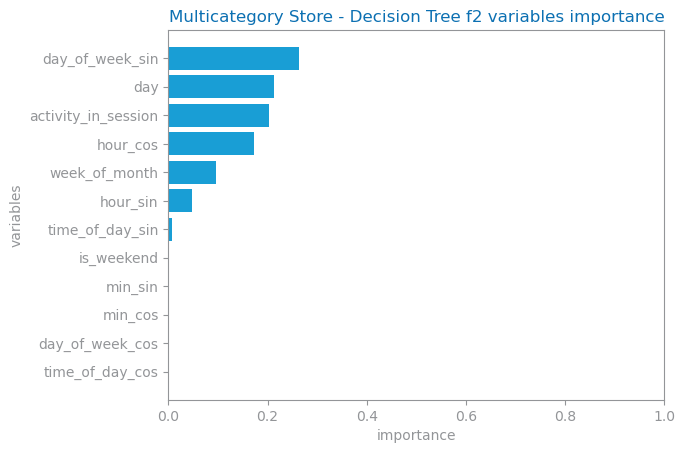

In [19]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} - Decision Tree {f2_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_vars_ranking.png")
show()

# f2 Overfitting

In [20]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit} - {eval_metric}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")

NameError: name 'params' is not defined

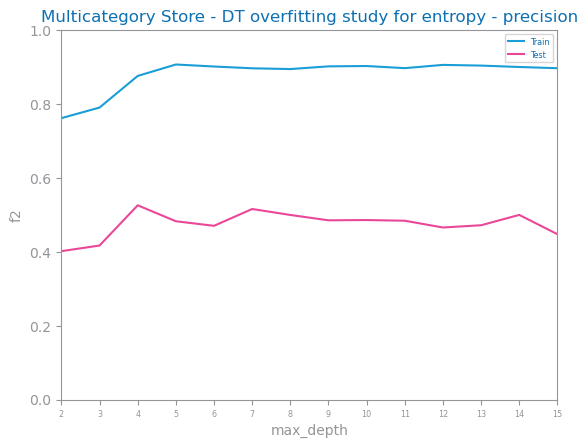

In [21]:
crit: Literal["entropy", "gini"] = f2_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} - DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(f2_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_overfitting.png")

# Precision - Variables Importance

## precision tree evaluation

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.27056 to fit


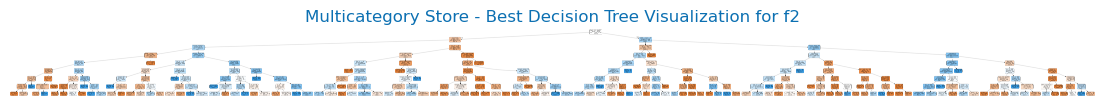

In [22]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis, title
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{prec_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_prec,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
title(f'{file_tag} - Best Decision Tree Visualization for {f2_params['metric']}')
axis("off")
show()

## precision simple tree

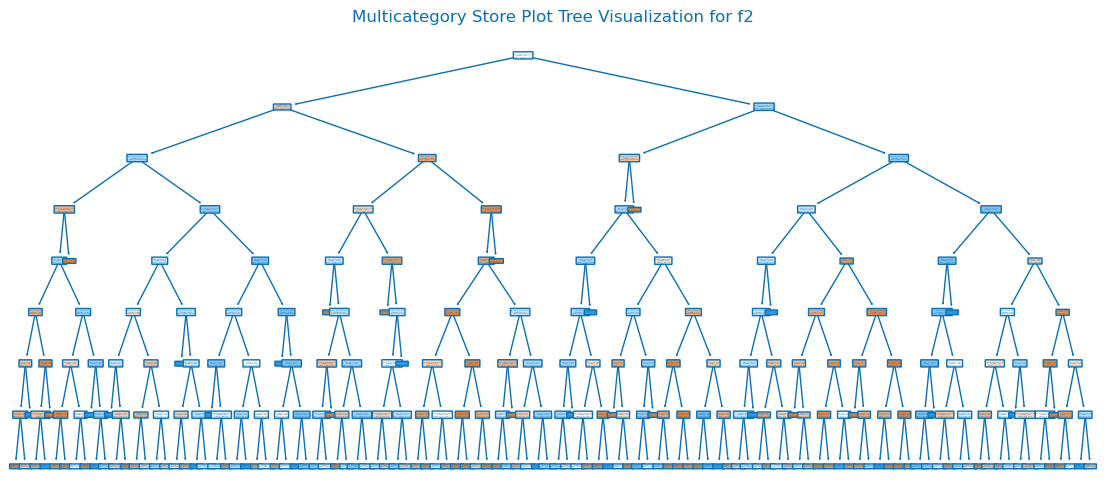

In [23]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model_prec,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")
title(f'{file_tag} Plot Tree Visualization for {f2_params['metric']}')

show()

## precision feature importance

1. day_of_week_sin (0.34156289597279194)
2. activity_in_session (0.20494928716434316)
3. hour_cos (0.19884516601611343)
4. day (0.12836362637989407)
5. hour_sin (0.05884575422883758)
6. day_of_week_cos (0.05250264655765351)
7. min_sin (0.007542459406462053)
8. min_cos (0.0069555962549404165)
9. week_of_month (0.000418027736701127)
10. is_weekend (1.4540282262896612e-05)
11. time_of_day_cos (0.0)
12. time_of_day_sin (0.0)


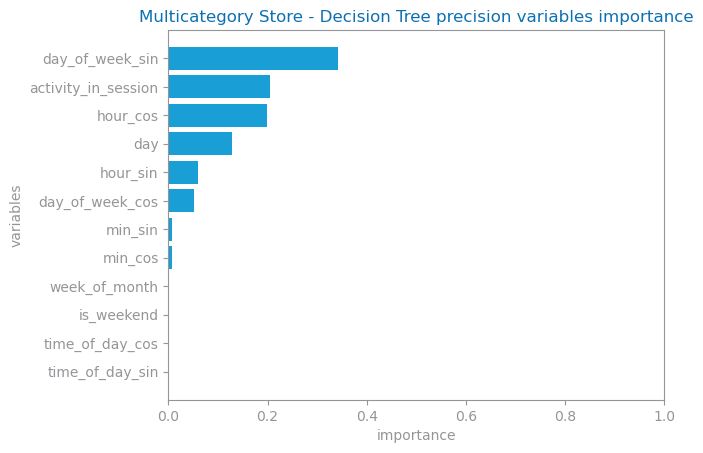

In [24]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} - Decision Tree {prec_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_vars_ranking.png")
show()

## precision overfitting

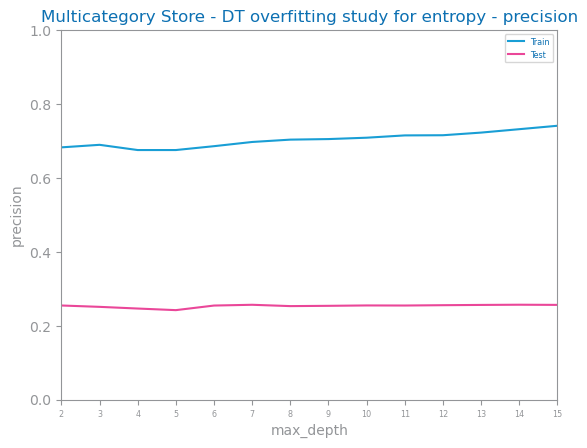

In [25]:
crit: Literal["entropy", "gini"] = prec_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} - DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(prec_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_overfitting.png")

# Analysis

- day_of week and then activity_session and week_of_month
- overfitting from level 3
